In [1]:
import os
import sys
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

sys.path.append('.')
sys.path.append('../../')
sys.path.append('../network_model/')

notebook_path = os.getcwd()
project_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(project_path)

from network_model.network_classes import Network
from networks_container import NetworksContainer
from estimator import Estimator

In [2]:
cherrypicked_seed = 42

seed(cherrypicked_seed)
random.seed(cherrypicked_seed)

In [3]:
dataset_obama = pd.read_csv("../datasets/obamaAnonimized.csv", dtype=str)

In [4]:
endorsers_percentage_list = pd.read_csv("../datasets/obama_endorsers_hours_percentage_list.csv", dtype=int, header=None)
endorsers_percentage_list = endorsers_percentage_list.values.tolist()
endorsers_percentage_list = [item for sublist in endorsers_percentage_list for item in sublist]

In [5]:
print(len(endorsers_percentage_list))

4730


In [6]:
# Tolgo 1 in quanto considero la prima epoca come lo stato iniziale
epochs = len(endorsers_percentage_list) - 1

In [7]:
print(len(dataset_obama))

4337


In [8]:
n_nodes = 2678
n_nodes

2678

In [9]:
n_bots = round((1 / 100) * n_nodes)
n_bots

27

In [10]:
n_fact_checkers = round((1 / 100) * n_nodes)
n_fact_checkers

27

In [11]:
n_influencers = 29

In [12]:
n_commons = n_nodes - n_bots - n_fact_checkers - n_influencers
n_commons

2595

In [13]:
n_initial_infected_nodes = round((1 / 100) * n_nodes) - n_bots
n_initial_infected_nodes

0

In [14]:
# Prendo i parametri calibrati con un dataset diverso da quello usato per la validazione
parameters_df = pd.read_csv("../validation/parameters/parameters_optimization_palin_hours_homophily_0.50.csv")

In [15]:
parameters_df = parameters_df.sort_values(by='rmse')
parameters_df

,alpha,beta,homophily,prob_infection,prob_vaccination,prob_cure,prob_influencer,prob_echo,rmse
16,0.50,0.33,0.5,0.360038,0.056790,0.216255,0.098907,0.617839,1.405257
17,0.50,0.50,0.5,0.454669,0.098769,0.211907,0.101289,0.250256,2.821633
15,0.50,0.25,0.5,0.308446,0.007363,0.157705,0.510944,0.549876,2.909999
19,0.75,0.25,0.5,0.448473,0.139018,0.030732,0.006663,0.825364,3.469475
9,0.25,0.75,0.5,0.471125,0.095869,0.172569,0.407868,0.015595,3.713381
12,0.33,0.33,0.5,0.317698,0.007074,0.214766,0.499534,0.120162,9.119578
13,0.33,0.50,0.5,0.439607,0.077711,0.071581,0.018257,0.299499,11.036833
8,0.25,0.50,0.5,0.481207,0.075433,0.153820,0.221028,0.824805,11.741975
6,0.25,0.25,0.5,0.418224,0.000221,0.119561,0.112658,0.001969,15.698193
4,0.00,0.75,0.5,0.437207,0.035077,0.234331,0.816667,0.986421,16.186571


In [16]:
alpha = parameters_df['alpha'].iloc[0]
beta = parameters_df['beta'].iloc[0]
homophily = parameters_df['homophily'].iloc[0]
prob_infection = parameters_df['prob_infection'].iloc[0]
prob_vaccination = parameters_df['prob_vaccination'].iloc[0]
prob_cure = parameters_df['prob_cure'].iloc[0]
prob_influencer = parameters_df['prob_influencer'].iloc[0]
prob_echo = parameters_df['prob_echo'].iloc[0]

In [17]:
container = NetworksContainer(n_networks=1, n_nodes=n_nodes, 
                              alpha=alpha, beta=beta, 
                              delta_in=1, delta_out=1, 
                              homophily=homophily, n_commons=n_commons, 
                              n_influencers=n_influencers, n_bots=n_bots, 
                              n_fact_checkers=n_fact_checkers,
                              prob_complaint=0.0, 
                              prob_infection=prob_infection, 
                              prob_vaccination=prob_vaccination,
                              prob_cure=prob_cure, 
                              prob_influencer=prob_influencer, 
                              exp_decay=True, user_block=False, 
                              prob_echo=prob_echo, epochs=epochs)
container.create_network_list(n_initial_infected_nodes=n_initial_infected_nodes)

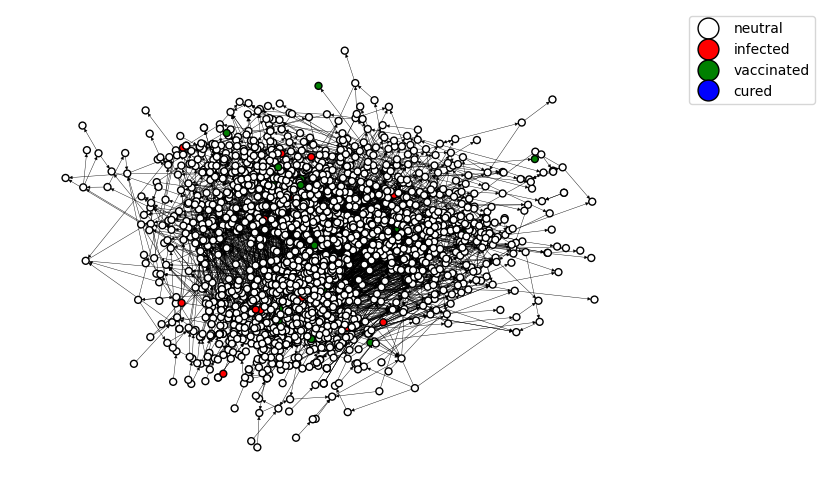

In [18]:
container.network_list[0].plot_graph_sirv()

In [19]:
for j in range(container.epochs):
    container.network_list[0].update_nodes()

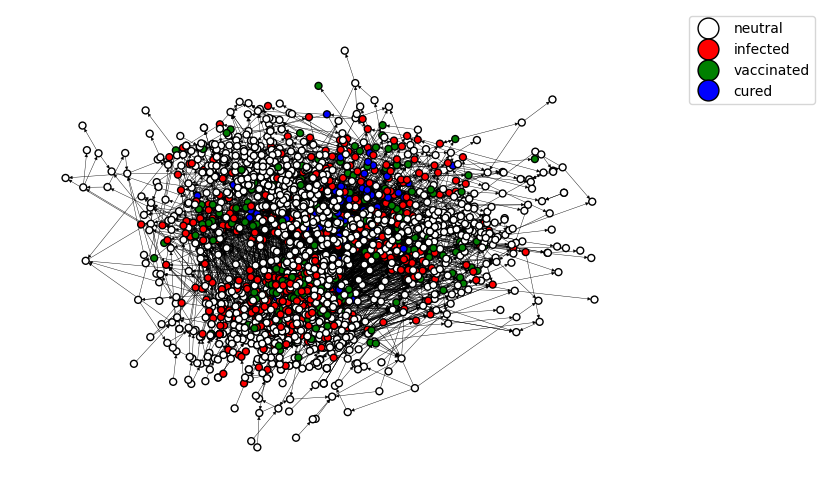

In [20]:
container.network_list[0].plot_graph_sirv()